# Setup

In [1]:
# File Operations Libraries
import os
import json
import cv2
import albumentations as A

# Standard Libraries
import numpy as np
import pandas as pd

# Graphing Libraries
import matplotlib.pyplot as plt
import seaborn as sn

#

In [2]:
# Base data path
BASE_DIR = "/home/akhil/Notebooks/Kaggle/Cassava Leaf Disease Classification/data"

# Data paths
FILE_PATH = "/home/akhil/Notebooks/Kaggle/Cassava Leaf Disease Classification/data/train_images/"
TEST_FILE_PATH = "/home/akhil/Notebooks/Kaggle/Cassava Leaf Disease Classification/data/test_images/"


In [3]:
with open(os.path.join(BASE_DIR, "label_num_to_disease_map.json")) as file:
    map_classes = json.loads(file.read())
    map_classes = {int(k) : v for k, v in map_classes.items()}
    
print(json.dumps(map_classes, indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [4]:
input_files = os.listdir(os.path.join(BASE_DIR, "train_images"))
print(f"Number of train images: {len(input_files)}")

Number of train images: 21397


In [5]:
img_shapes = {}
for image_name in os.listdir(os.path.join(BASE_DIR, "train_images"))[:300]:
    image = cv2.imread(os.path.join(BASE_DIR, "train_images", image_name))
    img_shapes[image.shape] = img_shapes.get(image.shape, 0) + 1

print(img_shapes)

{(600, 800, 3): 300}


In [6]:
df_train = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))

df_train["class_name"] = df_train["label"].map(map_classes)

df_train

image_id  label                           class_name
0      1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1      1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2       100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3      1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4      1000812911.jpg      3         Cassava Mosaic Disease (CMD)
...               ...    ...                                  ...
21392   999068805.jpg      3         Cassava Mosaic Disease (CMD)
21393   999329392.jpg      3         Cassava Mosaic Disease (CMD)
21394   999474432.jpg      1  Cassava Brown Streak Disease (CBSD)
21395   999616605.jpg      4                              Healthy
21396   999998473.jpg      4                              Healthy

[21397 rows x 3 columns]

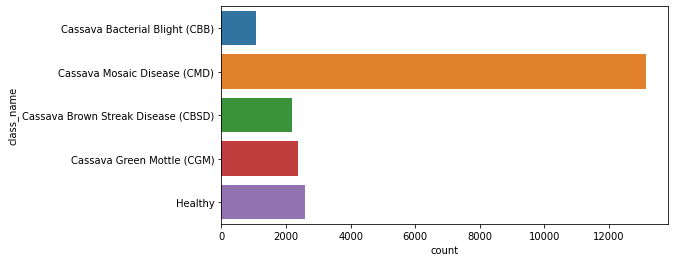

In [7]:
plt.figure(figsize=(8, 4))
sn.countplot(y="class_name", data=df_train);

# Data Visulaisation

In [8]:
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind + 1)
        image = cv2.imread(os.path.join(BASE_DIR, "train_images", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

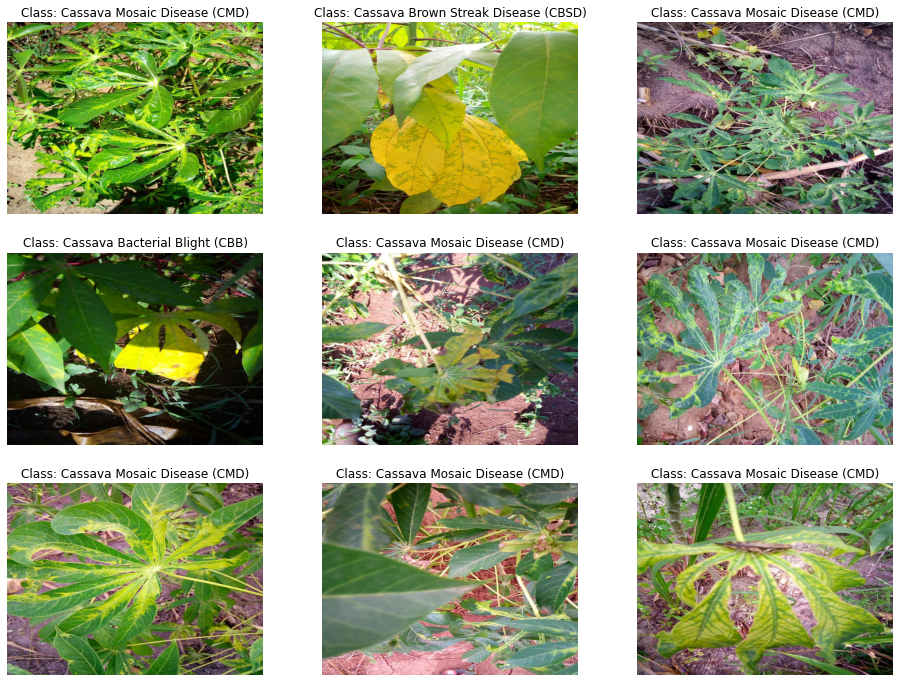

In [9]:
tmp_df = df_train.sample(9)
image_ids = tmp_df["image_id"].values
labels = tmp_df["class_name"].values

visualize_batch(image_ids, labels)

Total train images for class 0: 1087


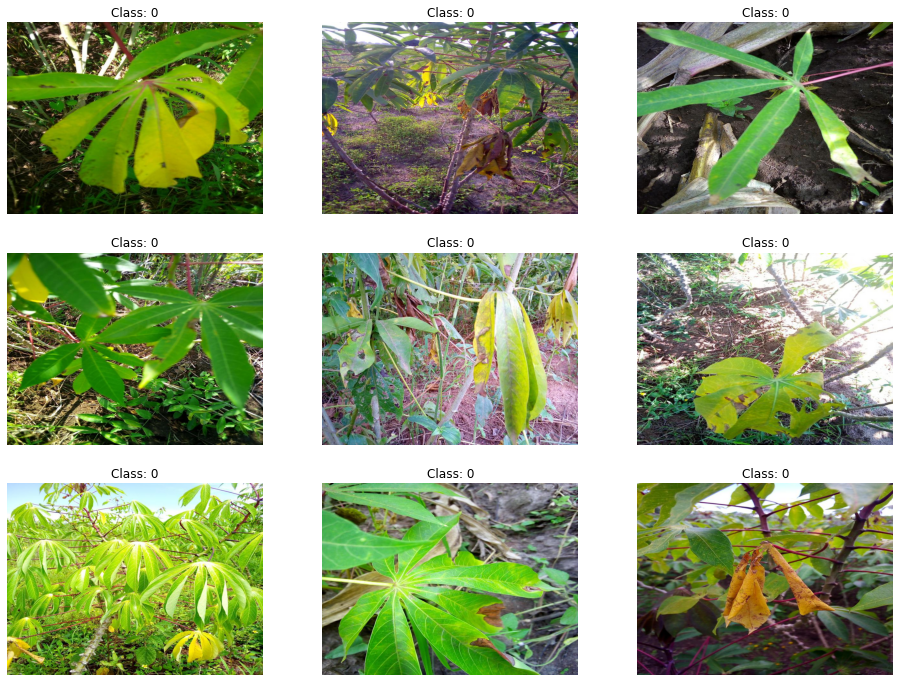

In [10]:
tmp_df = df_train[df_train["label"] == 0]
print(f"Total train images for class 0: {tmp_df.shape[0]}")

tmp_df = tmp_df.sample(9)
image_ids = tmp_df["image_id"].values
labels = tmp_df["label"].values

visualize_batch(image_ids, labels)

# Transforms

In [12]:
def plot_augmentation(image_id, transform):
    plt.figure(figsize=(16, 4))
    img = cv2.imread(os.path.join(BASE_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    x = transform(image=img)["image"]
    plt.imshow(x)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    x = transform(image=img)["image"]
    plt.imshow(x)
    plt.axis("off")
    
    plt.show()

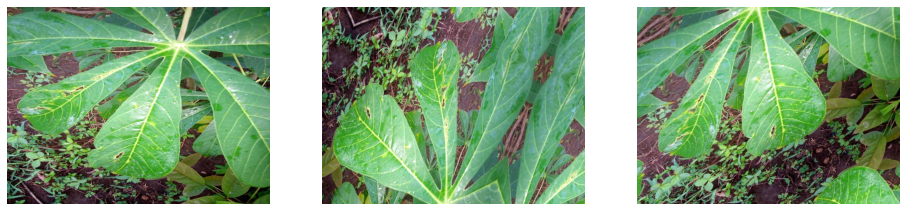

In [13]:
transform_shift_scale_rotate = A.ShiftScaleRotate(
    p=1.0, 
    shift_limit=(-0.3, 0.3), 
    scale_limit=(-0.1, 0.1), 
    rotate_limit=(-180, 180), 
    interpolation=0, 
    border_mode=4, 
)

plot_augmentation("1003442061.jpg", transform_shift_scale_rotate)

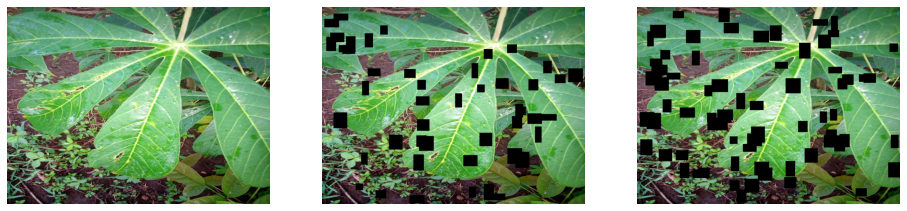

In [14]:
transform_coarse_dropout = A.CoarseDropout(
    p=1.0, 
    max_holes=100, 
    max_height=50, 
    max_width=50, 
    min_holes=30, 
    min_height=20, 
    min_width=20,
)

plot_augmentation("1003442061.jpg", transform_coarse_dropout)

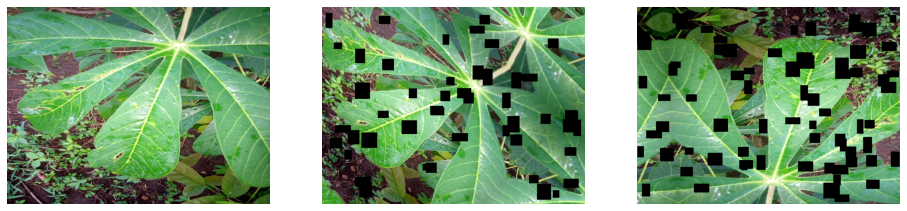

In [15]:
transform = A.Compose(
    transforms=[
        transform_shift_scale_rotate,
        transform_coarse_dropout,
    ],
    p=1.0,
)

plot_augmentation("1003442061.jpg", transform)

In [16]:
df_sub = pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv", index_col=0)
for pred_class in range(0, 5):
    y_true = df_train["label"].values
    y_pred = np.full_like(y_true, pred_class)
    print(f"accuracy score (predict {pred_class}): {sk_metrics.accuracy_score(y_true, y_pred):.3f}")

df_sub["label"] = 3
df_sub.to_csv("submission.csv")

FileNotFoundError: [Errno 2] File b'../input/cassava-leaf-disease-classification/sample_submission.csv' does not exist: b'../input/cassava-leaf-disease-classification/sample_submission.csv'